# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
#importing libraries to be used in assignment
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# [1]. Reading Data

In [2]:
# Loading Pre-Processed data( Reviews ) from database
conn = sqlite3.connect('final_database.sqlite')
data = pd.read_sql_query('''SELECT * FROM Reviews''',conn)

In [3]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [4]:
# Sorting data in ascending order wrt time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time")

In [5]:
data["Score"].value_counts()

positive    307061
negetive     57110
Name: Score, dtype: int64

In [6]:
def Partition(x):
    if x == "positive":
        return 1
    else:
        return 0
    
actual_score = data['Score']
pone = actual_score.map(Partition)
data['Score'] = pone

data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [7]:
data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [8]:
X = data["CleanText"]
y = data["Score"]

In [9]:
#Sampling 100k data pts in 70:30 train test

X = X.iloc[1:10001]
y = y.iloc[1:10001]


print(X.shape,y.shape)

(10000,) (10000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [41]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X = count_vect.fit_transform(X)

print("the type of count vectorizer ",type(X))
print("the shape of out text BOW vectorizer ",X.get_shape())
print("the number of unique words ", X.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 48928)
the number of unique words  48928


## [4.3] TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()
X = tf_idf_vect.fit_transform(X)

## [4.4] Word2Vec

In [34]:
# Trainning Word2Vec model using own text corpus
i=0
list_of_sent=[]
for sent in X.values: 
    list_of_sent.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
import warnings
warnings.filterwarnings("ignore")

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=3)

w2v_words = list(w2v_model.wv.vocab)

### [4.3.1] Avg. word2vec

In [11]:
# training data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
X = sent_vectors

2000
50


### [4.3.2] tfidf word2vec

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
from tqdm import tqdm

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X = tfidf_sent_vectors

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 614.58it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [11]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    loss.append(kmeans.inertia_)

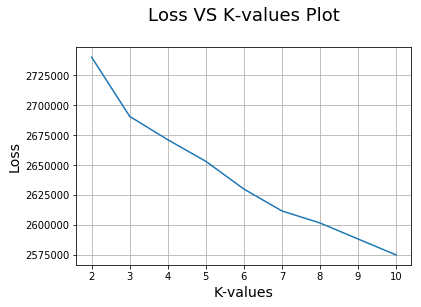

In [12]:
# Draw Loss VS K values plot
plt.plot(k, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

Observation : As slope is falling sligtly suddenly, so k = 4 is optimal

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

No. of reviews in Cluster-1 :  2143

No. of reviews in Cluster-2 :  41602

No. of reviews in Cluster-3 :  279

No. of reviews in Cluster-4 :  5976


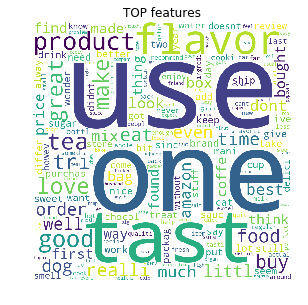

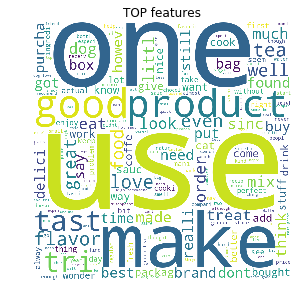

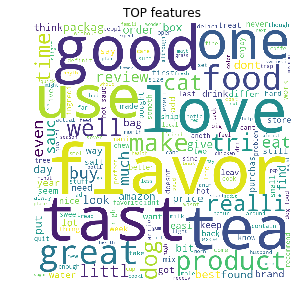

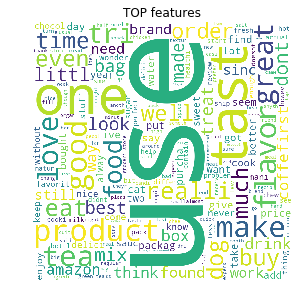

In [42]:
# Please write all the code with proper documentationkmeans = KMeans(n_clusters=4, n_jobs=-1)
kmeans.fit(X)
reviews = data["CleanText"]
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster = [cluster1,cluster2,cluster3,cluster4]
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

for j in range(4):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [11]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    loss.append(kmeans.inertia_)

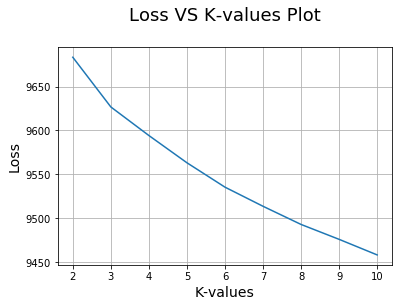

In [12]:
# Draw Loss VS K values plot
plt.plot(k, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

Observation : As slope is falling sligtly suddenly, so k = 3 is optimal

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

No. of reviews in Cluster-1 :  605

No. of reviews in Cluster-2 :  8321

No. of reviews in Cluster-3 :  1074


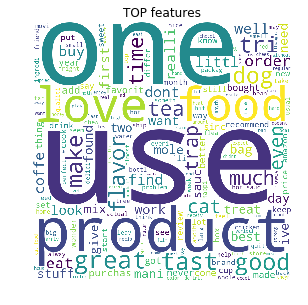

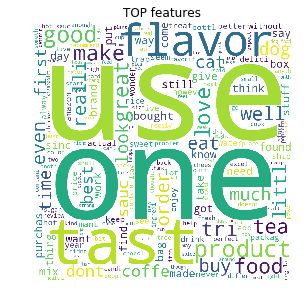

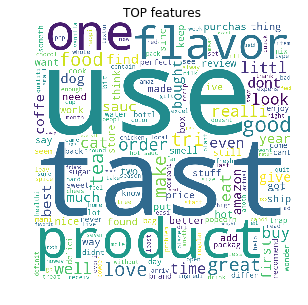

In [15]:
from wordcloud import WordCloud, STOPWORDS
kmeans = KMeans(n_clusters=3, n_jobs=-1)
kmeans.fit(X)
reviews = data["CleanText"]
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster = [cluster1,cluster2,cluster3]
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    else :
        cluster3.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))

for j in range(3):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
    plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [54]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    loss.append(kmeans.inertia_)

In [ ]:
# Draw Loss VS K values plot
plt.plot(k, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

Observation : As slope is falling sligtly suddenly, so k = 3 is optimal

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

No. of reviews in Cluster-1 :  18863

No. of reviews in Cluster-2 :  8204

No. of reviews in Cluster-3 :  22933


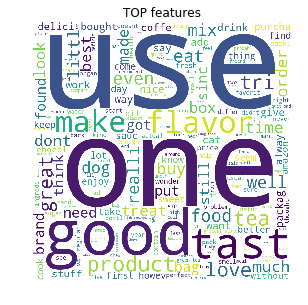

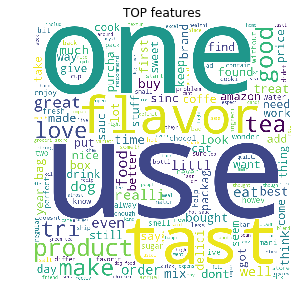

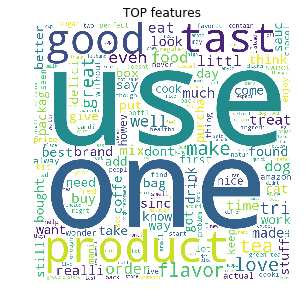

In [61]:
kmeans = KMeans(n_clusters=3, n_jobs=-1)
kmeans.fit(X)
reviews = data["CleanText"]
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster = [cluster1,cluster2,cluster3]
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    else :
        cluster3.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))

for j in range(3):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
    plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [72]:
# Please write all the code with proper documentation# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    loss.append(kmeans.inertia_)

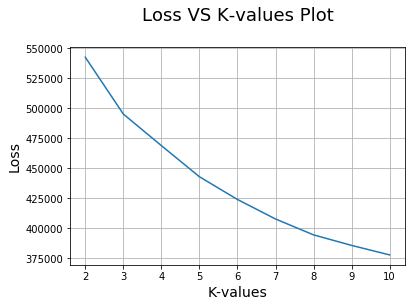

In [73]:
# Draw Loss VS K values plot
plt.plot(k, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

Observation : As slope is falling sligtly suddenly, so k = 4 is optimal

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

No. of reviews in Cluster-1 :  12648

No. of reviews in Cluster-2 :  6032

No. of reviews in Cluster-3 :  6164

No. of reviews in Cluster-4 :  25156


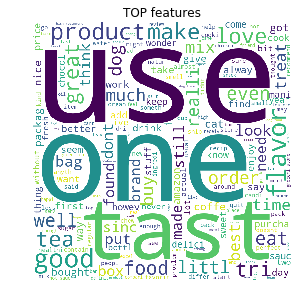

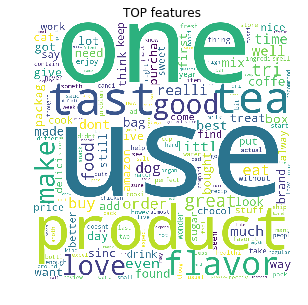

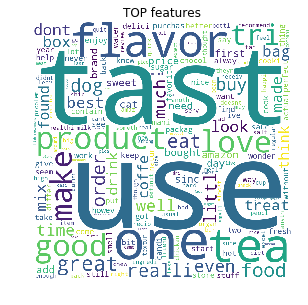

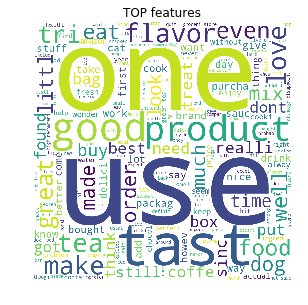

In [74]:
# Please write all the code with proper documentation
# Please write all the code with proper documentationkmeans = KMeans(n_clusters=4, n_jobs=-1)
kmeans.fit(X)
reviews = data["CleanText"]
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster = [cluster1,cluster2,cluster3,cluster4]
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

for j in range(4):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [23]:
# clusters = 2
from sklearn.cluster import AgglomerativeClustering as AC

model = AC(n_clusters=2,linkage="average")
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2,
            pooling_func=<function mean at 0x000001E4B2791A60>)

In [32]:
# clusters = 5
from sklearn.cluster import AgglomerativeClustering as AC

model = AC(n_clusters=5,linkage="average")
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=5,
            pooling_func=<function mean at 0x000001E4B2791A60>)

In [28]:
# clusters = 8
from sklearn.cluster import AgglomerativeClustering as AC

model = AC(n_clusters=8,linkage="average")
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=8,
            pooling_func=<function mean at 0x000001E4B2791A60>)

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

No. of reviews in Cluster-1 :  1993

No. of reviews in Cluster-2 :  7


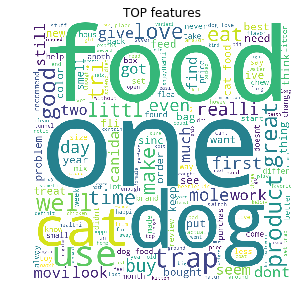

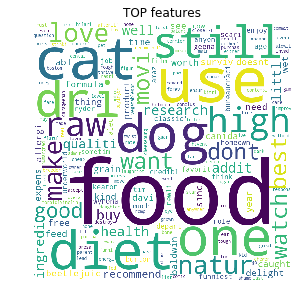

In [24]:
# word cloud with # clusters = 2
from wordcloud import WordCloud, STOPWORDS
reviews = data["CleanText"]
cluster1 = []
cluster2 = []
cluster = [cluster1,cluster2]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

for j in range(2):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

No. of reviews in Cluster-1 :  1582

No. of reviews in Cluster-2 :  314

No. of reviews in Cluster-3 :  97

No. of reviews in Cluster-4 :  1

No. of reviews in Cluster-5 :  6


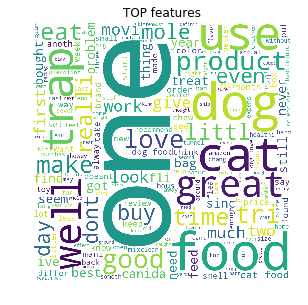

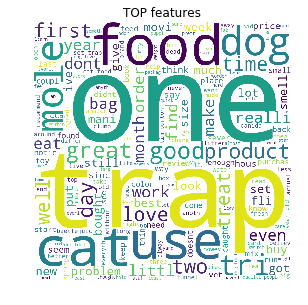

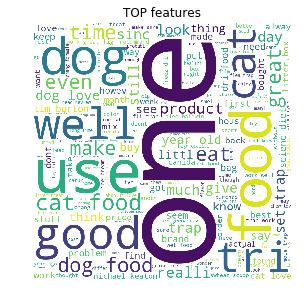

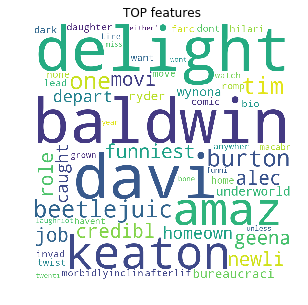

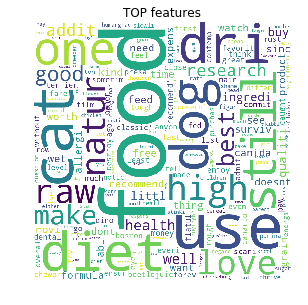

In [33]:
# word cloud with # clusters = 5
from wordcloud import WordCloud, STOPWORDS
reviews = data["CleanText"]
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster = [cluster1,cluster2,cluster,cluster4,cluster5]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

for j in range(5):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

No. of reviews in Cluster-1 :  88

No. of reviews in Cluster-2 :  6

No. of reviews in Cluster-3 :  1062

No. of reviews in Cluster-4 :  46

No. of reviews in Cluster-5 :  268

No. of reviews in Cluster-6 :  520

No. of reviews in Cluster-7 :  9

No. of reviews in Cluster-8 :  1


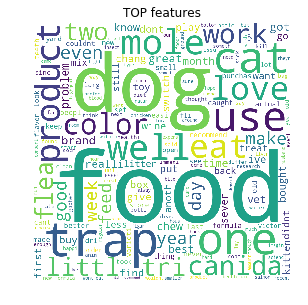

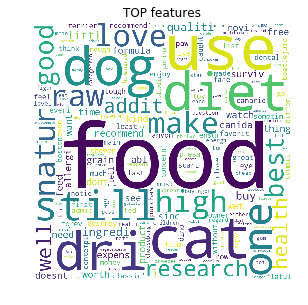

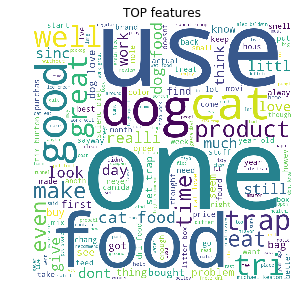

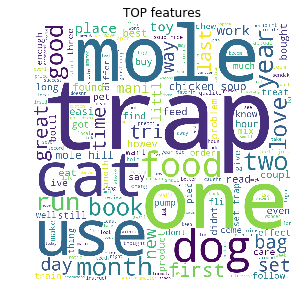

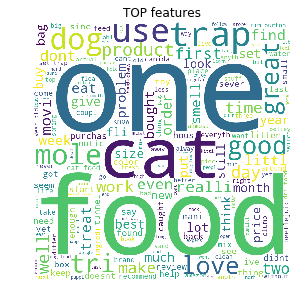

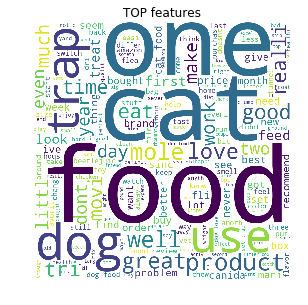

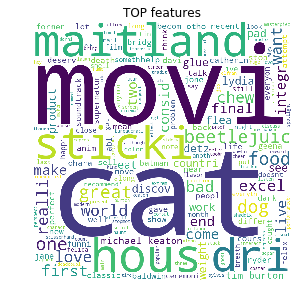

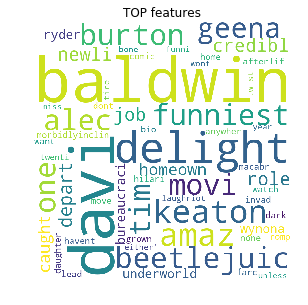

In [31]:
# word cloud with # clusters = 8
from wordcloud import WordCloud, STOPWORDS
reviews = data["CleanText"]
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster = [cluster1,cluster2,cluster,cluster4,cluster5,cluster6,cluster7,cluster8]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif model.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif model.labels_[i] == 5:
        cluster6.append(reviews[i])
    elif model.labels_[i] == 6:
        cluster7.append(reviews[i])
    else :
        cluster8.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))


for j in range(8):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [44]:
# Please write all the code with proper documentation
# clusters = 2
from sklearn.cluster import AgglomerativeClustering as AC

model = AC(n_clusters=2,linkage="average")
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2,
            pooling_func=<function mean at 0x000001E4B2791A60>)

In [46]:
# clusters = 5
from sklearn.cluster import AgglomerativeClustering as AC

model = AC(n_clusters=5,linkage="average")
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=5,
            pooling_func=<function mean at 0x000001E4B2791A60>)

In [48]:
# clusters = 8
from sklearn.cluster import AgglomerativeClustering as AC

model = AC(n_clusters=8,linkage="average")
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=8,
            pooling_func=<function mean at 0x000001E4B2791A60>)

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

No. of reviews in Cluster-1 :  1611

No. of reviews in Cluster-2 :  389


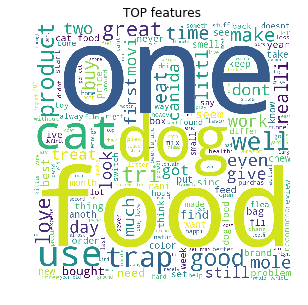

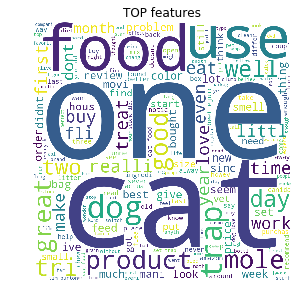

In [45]:
# Please write all the code with proper documentation
# word cloud with # clusters = 2
from wordcloud import WordCloud, STOPWORDS
reviews = data["CleanText"]
cluster1 = []
cluster2 = []
cluster = [cluster1,cluster2]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

for j in range(2):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

No. of reviews in Cluster-1 :  371

No. of reviews in Cluster-2 :  345

No. of reviews in Cluster-3 :  1240

No. of reviews in Cluster-4 :  41

No. of reviews in Cluster-5 :  3


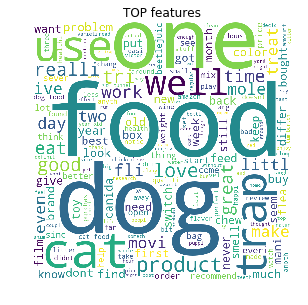

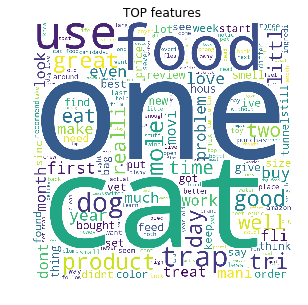

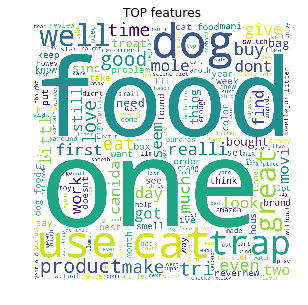

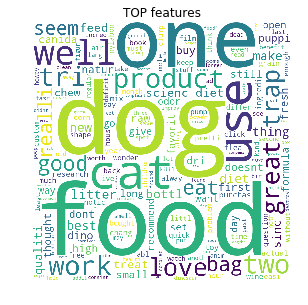

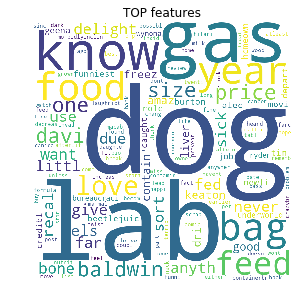

In [47]:
# word cloud with # clusters = 5
from wordcloud import WordCloud, STOPWORDS
reviews = data["CleanText"]
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster = [cluster1,cluster2,cluster,cluster4,cluster5]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

for j in range(5):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

No. of reviews in Cluster-1 :  345

No. of reviews in Cluster-2 :  15

No. of reviews in Cluster-3 :  322

No. of reviews in Cluster-4 :  41

No. of reviews in Cluster-5 :  3

No. of reviews in Cluster-6 :  729

No. of reviews in Cluster-7 :  511

No. of reviews in Cluster-8 :  34


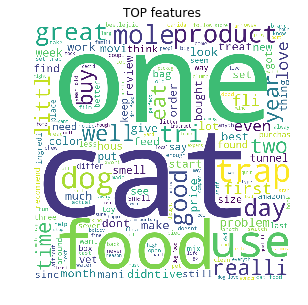

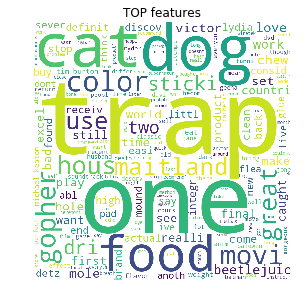

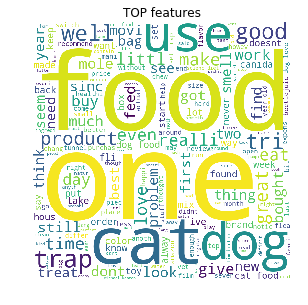

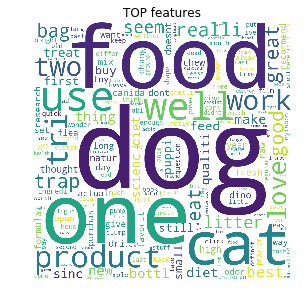

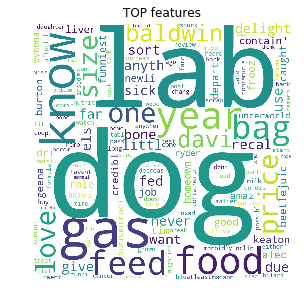

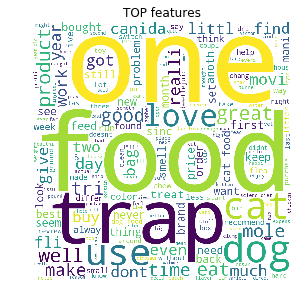

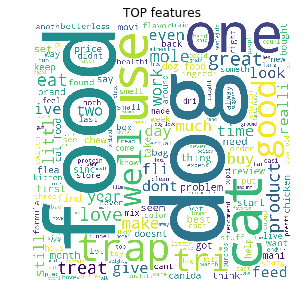

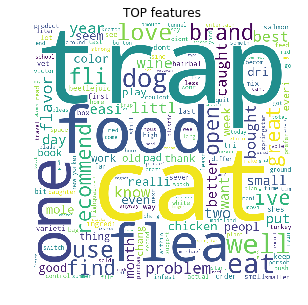

In [49]:
# word cloud with # clusters = 8
from wordcloud import WordCloud, STOPWORDS
reviews = data["CleanText"]
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster = [cluster1,cluster2,cluster,cluster4,cluster5,cluster6,cluster7,cluster8]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif model.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif model.labels_[i] == 5:
        cluster6.append(reviews[i])
    elif model.labels_[i] == 6:
        cluster7.append(reviews[i])
    else :
        cluster8.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))


for j in range(8):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

## [5.3] DBSCAN Clustering

In [13]:
# function to determinethe distance of nth-nearest neighbour to all points 
def n_ngb(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))
# Function definition for implementing DBSCAN
def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    return db

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

<strong>Elbow Method</strong>

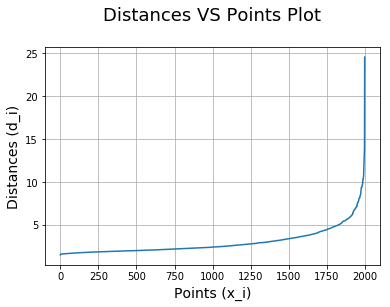

In [20]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

min_points = 2*X.shape[1]
# Computing distances of nth-nearest neighbours
distances = n_ngb(X,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(X.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

Observation : From above curve, we can conclude that eps value is 5, as the curve is drasticaly changing(i.e di's are high/Noise)

In [21]:
dbscan(5, min_points, X)

Number of clusters for MinPts = 100 and Epsilon = 5.000000 is : 2 


DBSCAN(algorithm='auto', eps=5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

In [22]:
dbscan(7, min_points, X)

Number of clusters for MinPts = 100 and Epsilon = 7.000000 is : 2 


DBSCAN(algorithm='auto', eps=7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

Number of clusters for MinPts = 100 and Epsilon = 5.000000 is : 2 
No. of reviews in Cluster-1 :  1962

No. of reviews in Cluster-2 :  38


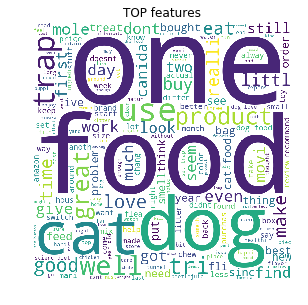

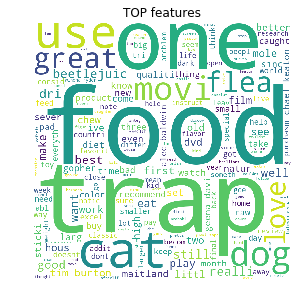

In [24]:
# Please write all the code with proper documentation
# word cloud with # clusters = 2
model = dbscan(5, min_points, X)
from wordcloud import WordCloud, STOPWORDS
reviews = data["CleanText"]
cluster1 = []
cluster2 = []
cluster = [cluster1,cluster2]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

for j in range(2):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

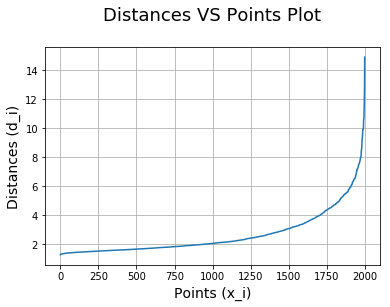

In [36]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

min_points = 2*X.shape[1]
# Computing distances of nth-nearest neighbours
distances = n_ngb(X,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(X.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

Observation : From above curve, we can conclude that eps value is 4, as the curve is drasticaly changing(i.e di's are high/Noise)

In [37]:
dbscan(4, min_points, X)

Number of clusters for MinPts = 100 and Epsilon = 4.000000 is : 2 


DBSCAN(algorithm='auto', eps=4, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

In [38]:
dbscan(6, min_points, X)

Number of clusters for MinPts = 100 and Epsilon = 6.000000 is : 2 


DBSCAN(algorithm='auto', eps=6, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

Number of clusters for MinPts = 100 and Epsilon = 4.000000 is : 2 
No. of reviews in Cluster-1 :  1902

No. of reviews in Cluster-2 :  98


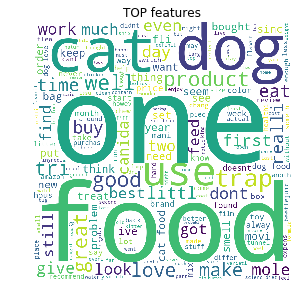

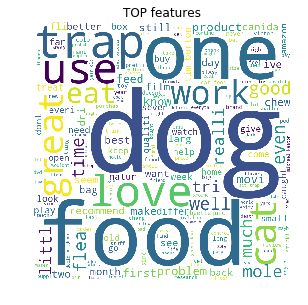

In [40]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# word cloud with # clusters = 2
model = dbscan(4, min_points, X)
from wordcloud import WordCloud, STOPWORDS
reviews = data["CleanText"]
cluster1 = []
cluster2 = []
cluster = [cluster1,cluster2]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

for j in range(2):
    wordcloud_n = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(str(cluster[j]))
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud_n) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('TOP features')
  
    plt.show()

# [6] Conclusions

<strong>Kmeans</strong>

In [16]:
# Please compare all your models using Prettytable library. 
table = {'Technique':['BoW', "TFIDF","Avg_w2v","tf-idf_w2v"],'k':['4','3','3','4'] }
df = pd.DataFrame(data=table)
df

,Technique,k
0,BoW,4
1,TFIDF,3
2,Avg_w2v,3
3,tf-idf_w2v,4


<strong>Agglomorative Clustering</strong>

In [20]:
print("avg w2v")
table = {'Cluster':['1','2','3','4','5'],'No. of reviews':['1582','314','97','1','6'] }
df = pd.DataFrame(data=table)
df

avg w2v


,Cluster,No. of reviews
0,1,1582
1,2,314
2,3,97
3,4,1
4,5,6


In [21]:
print("tfidf w2v")
table = {'Cluster':['1','2','3','4','5'],'No. of reviews':['371','345','1240','41','3'] }
df = pd.DataFrame(data=table)
df

tfidf w2v


,Cluster,No. of reviews
0,1,371
1,2,345
2,3,1240
3,4,41
4,5,3


<strong>DBSCAN</strong>

In [22]:
# Please compare all your models using Prettytable library. 
table = {'Technique':["Avg_w2v","tf-idf_w2v"],'eps':['5','4'],'min pts':['100','100'],'clusters':['2','2'] }
df = pd.DataFrame(data=table)
df

,Technique,eps,min pts,clusters
0,Avg_w2v,5,100,2
1,tf-idf_w2v,4,100,2


In [23]:
print("end")

end
